In [17]:
import torch
import sys
import numpy as np
sys.path.append('..')
sys.path.append('../main')
from utils import utils
from main.gt_sampling import get_sample
import model
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.multioutput import MultiOutputRegressor

In [3]:
problem_f24 = utils.create_problem(24, 2, 42)

c:\Users\User\.conda\envs\MachineLearningProject\lib\site-packages\bbobtorch\utils.py:44: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2431.)
  R, _ = t.qr(R)


In [4]:
sample_f24 = get_sample(problem_f24, n_samples=1000, n_dim=2, seed=42, method='random')

c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theoriephase\Machine Learning Project (W3WI_DS305.2)\OptimizationTestfunctionGeneration\misc\..\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()


In [5]:
data = sample_f24
problem = problem_f24
X_input = torch.tensor(data[0], dtype=torch.float32).clone().detach()
y_input = data[1]
y_input_grad1 = torch.tensor(np.concatenate((y_input.reshape(-1,1), data[2]), axis=1), dtype=torch.float32).clone().detach()
y_input_grad2 = torch.tensor(np.concatenate((y_input.reshape(-1,1), data[2], data[3]), axis=1), dtype=torch.float32).clone().detach()         

C:\Users\User\AppData\Local\Temp\ipykernel_27096\3131514030.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_input = torch.tensor(data[0], dtype=torch.float32).clone().detach()


In [141]:
n_in=2
n_out=5
n_hidden=32
hidden_layers=16
learning_rate = 1e-3
num_epochs = 8000

m = model.NN_(n_in, n_out, n_hidden, hidden_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)

In [142]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
y_input_grad2_ = torch.tensor(scaler.fit_transform(y_input_grad2), dtype=torch.float32).clone().detach()

In [143]:
# Training loop for m1
for epoch in range(num_epochs):
    # Forward pass
    outputs = m(X_input)
    loss = criterion(y_input_grad2_, outputs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/8000], Loss: 1.0062
Epoch [20/8000], Loss: 1.0021
Epoch [30/8000], Loss: 1.0004
Epoch [40/8000], Loss: 0.9987
Epoch [50/8000], Loss: 0.9805
Epoch [60/8000], Loss: 0.9470
Epoch [70/8000], Loss: 0.9158
Epoch [80/8000], Loss: 0.8967
Epoch [90/8000], Loss: 0.8857
Epoch [100/8000], Loss: 0.8773
Epoch [110/8000], Loss: 0.8740
Epoch [120/8000], Loss: 0.8731
Epoch [130/8000], Loss: 0.8714
Epoch [140/8000], Loss: 0.8695
Epoch [150/8000], Loss: 0.8669
Epoch [160/8000], Loss: 0.8651
Epoch [170/8000], Loss: 0.8633
Epoch [180/8000], Loss: 0.8617
Epoch [190/8000], Loss: 0.8608
Epoch [200/8000], Loss: 0.8600
Epoch [210/8000], Loss: 0.8590
Epoch [220/8000], Loss: 0.8580
Epoch [230/8000], Loss: 0.8572
Epoch [240/8000], Loss: 0.8563
Epoch [250/8000], Loss: 0.8554
Epoch [260/8000], Loss: 0.8546
Epoch [270/8000], Loss: 0.8536
Epoch [280/8000], Loss: 0.8532
Epoch [290/8000], Loss: 0.8526
Epoch [300/8000], Loss: 0.8522
Epoch [310/8000], Loss: 0.8526
Epoch [320/8000], Loss: 0.8515
Epoch [330/8000],

In [144]:
# generate mesh grid for plotting
with torch.no_grad():
    x = np.linspace(-5.0, 5.0, 100)
    y = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(x, y)
  
    mesh_samples = np.c_[X.ravel(), Y.ravel()]
    mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
    mesh_results = m(mesh_samples_tensor)[:,0].reshape(X.shape)

<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

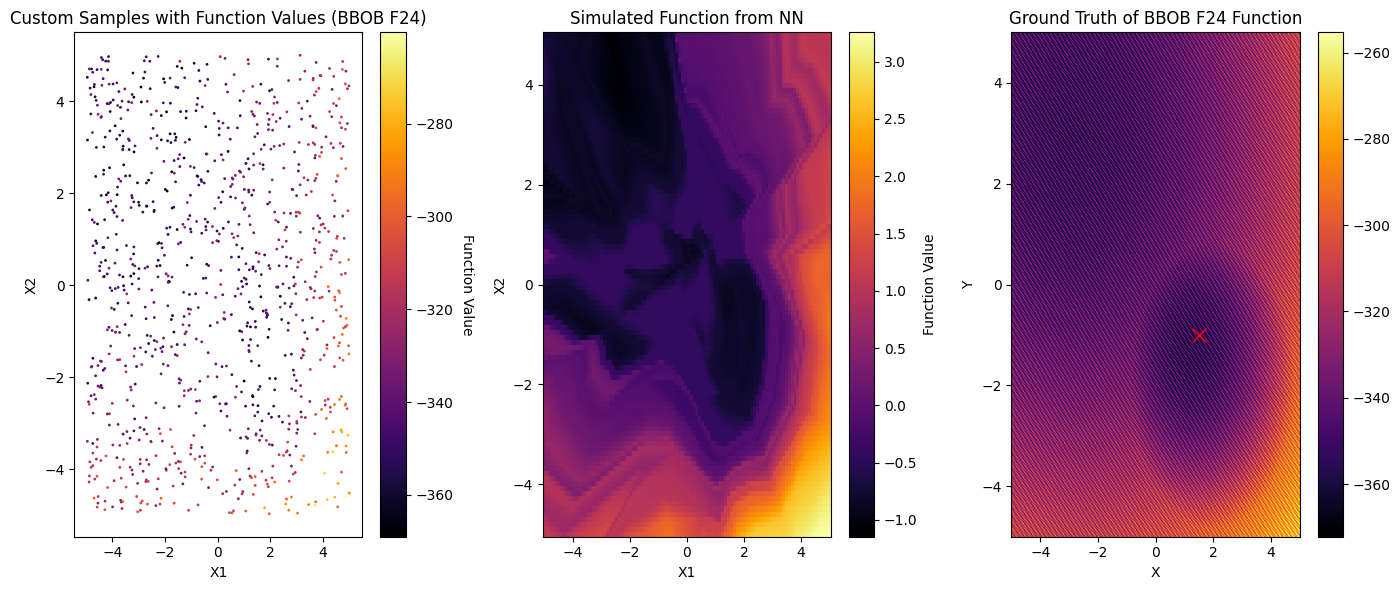

In [145]:
utils.plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", "NN", X, Y, mesh_results)

In [88]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=100, gamma=1)),
])

In [89]:
svr = MultiOutputRegressor(pipe)

In [90]:
svr.fit(X_input, y_input_grad2)

MultiOutputRegressor(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model', SVR(C=100, gamma=1))]))

In [91]:
# generate mesh grid for plotting
with torch.no_grad():
    x = np.linspace(-5.0, 5.0, 100)
    y = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(x, y)
  
    mesh_samples = np.c_[X.ravel(), Y.ravel()]
    mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
    mesh_results = svr.predict(mesh_samples_tensor)[:,0].reshape(X.shape)

<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

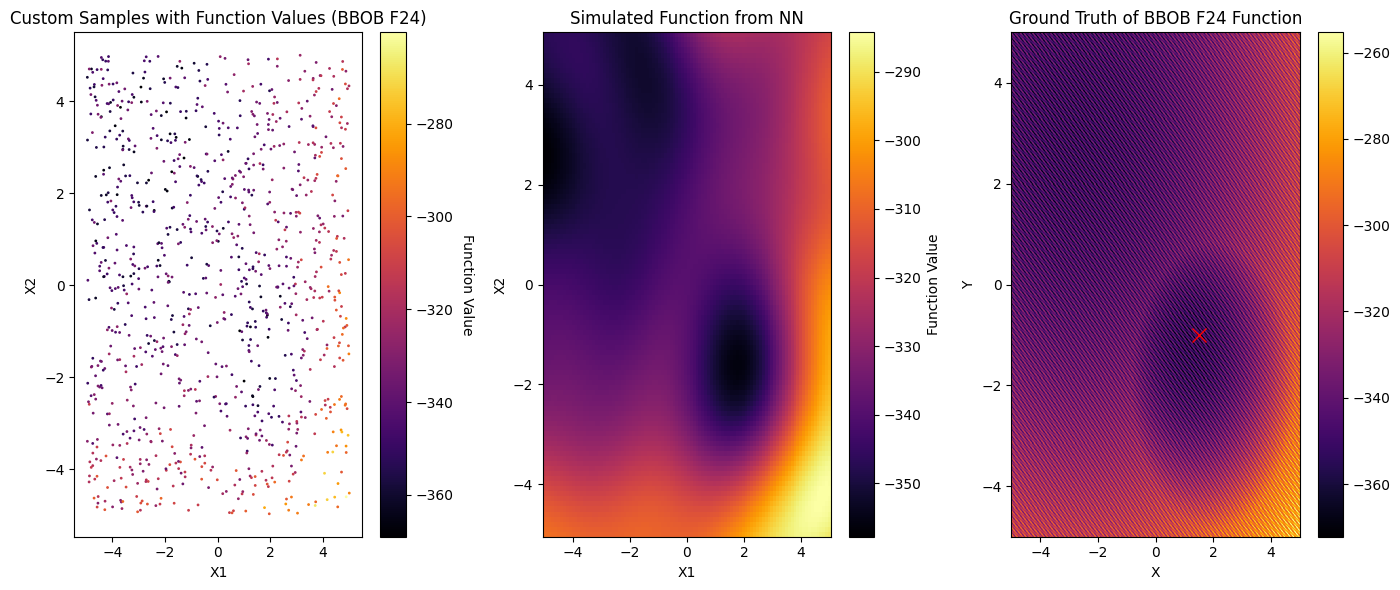

In [92]:
utils.plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", "NN", X, Y, mesh_results)